# neuroCombat on ADNI

NeuroCombat is a multi-site harmonization method in Python. The method was introduced in the paper [“Harmonization of cortical thickness measurements across scanners and sites”  by Fortin et al](https://www.sciencedirect.com/science/article/pii/S105381191730931X?via%3Dihub). The original code and package can be found here: https://github.com/Jfortin1/neuroCombat. In summary, it can be used to account for variations in the data that originate from using different scanners and scanning sites. This is useful as the MRI scanner and site used leads to slight inconsistencies even in scans of the same subject. Therefore, neuroCombat can adjust, for example, FreeSurfer volume measures based on the site the data was acquired. 

In this workshop, we will be applying NeuroCombat on ADNI data, and visualise the effects of NeuroCombat on the data. Specifically, the ADNIMERGE file (downloaded on April 27th, 2022) will be used. 

## Table of Contents:
* [Importing](#first-bullet)
* [Visualizing the Data](#second-bullet)
* [Understanding neuroCombat](#third-bullet)
* [Applying neuroCombat](#fourth-bullet)
* [Visualizing the Results](#fifth-bullet)
* [Conclusion](#sixth-bullet)

## Importing <a class="anchor" id="first-bullet"></a>

In [1]:
# Import Packages 
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt, cbook as cbook
import seaborn as sns

from neuroCombat import neuroCombat

In [2]:
# Import the Data 
df_adni = pd.read_csv('ADNIMERGE_220427.csv',low_memory=False)

Next, in order to apply neuroCombat and perform data harmonization, we first need to understand the inputs and outputs of the function. The below cell is an excerpt from what can be found on: https://github.com/Jfortin1/neuroCombat, to aid us in our task.

## Visualizing the Data <a class="anchor" id="second-bullet"></a>

In the original neuroCombat paper, the authors compare the median cortical thickness (i.e. the median of all the FreeSurfer values per patient) for each site. In this case, as we only have 5 FreeSurfer measures in our dataset, we will just be looking at the Hippocampus and WholeBrain as examples. 

### Site Effects

In [3]:
# Setting the Seaborn Color Palette
sns.set_palette('Set2')

C:\Users\shawa_byzwpna\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Hippocampal Volume')

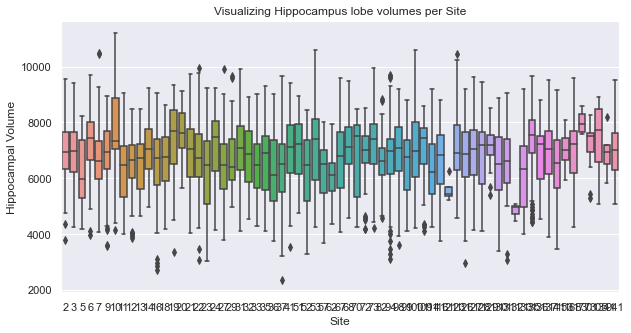

In [23]:
# Per Site
plt.figure(figsize = (10,5))
sns.boxplot(df_adni['SITE'].values, df_adni['Hippocampus'].values)
plt.title('Visualizing Hippocampus lobe volumes per Site')
plt.xlabel('Site')
plt.ylabel('Hippocampal Volume')

C:\Users\shawa_byzwpna\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Hippocampal Volume')

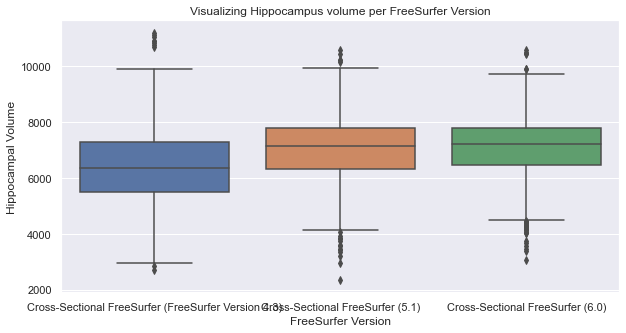

In [24]:
# Per FreeSurfer Software Version
plt.figure(figsize = (10,5))
sns.boxplot(df_adni['FSVERSION'].values, df_adni['Hippocampus'].values)
plt.title('Visualizing Hippocampus volume per FreeSurfer Version')
plt.xlabel('FreeSurfer Version')
plt.ylabel('Hippocampal Volume')

### Covariates Distribution

Text(25.874024999999996, 0.5, 'Count')

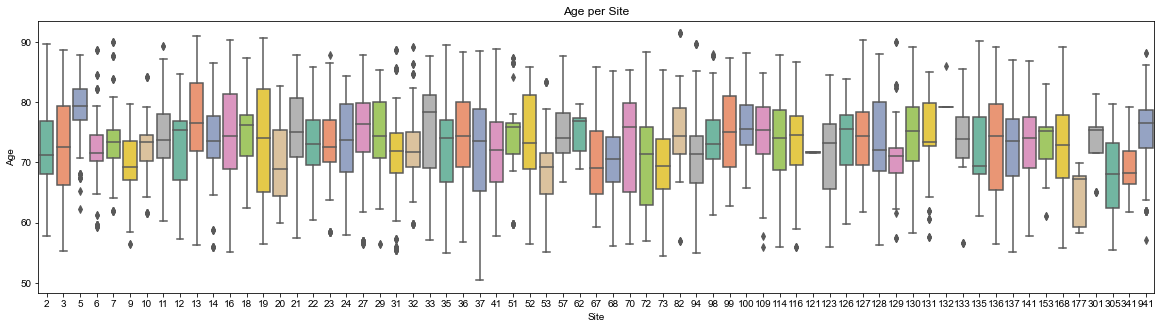

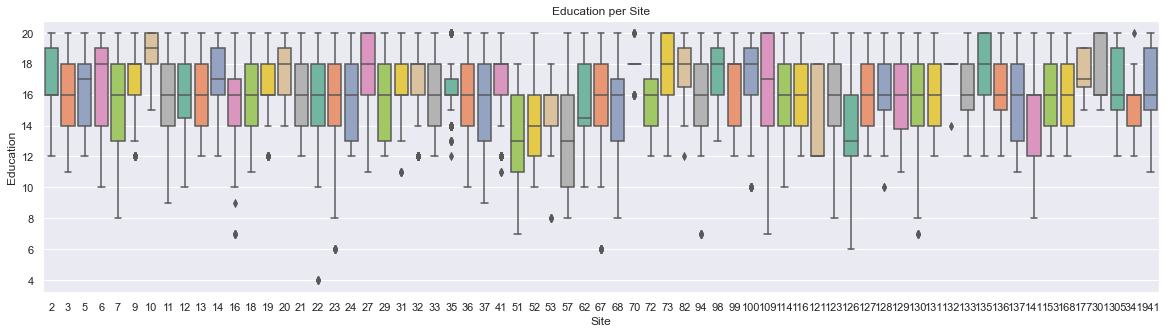

<Figure size 1440x360 with 0 Axes>

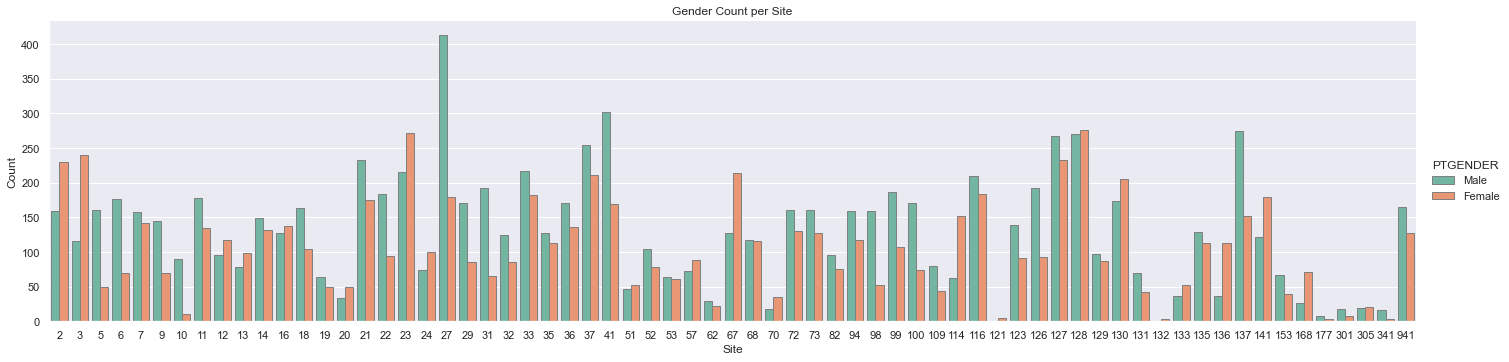

In [6]:
# Boxplots of Age per Site
fig = plt.figure(figsize = (20,5))
sns.boxplot(data = df_adni, x = 'SITE', y = 'AGE', palette="Set2")
plt.title('Age per Site')
plt.xlabel('Site')
plt.ylabel('Age')

# Boxplot of Education per Site
fig = plt.figure(figsize = (20,5))
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(data = df_adni, x = 'SITE', y = 'PTEDUCAT', palette="Set2")
plt.title('Education per Site')
plt.xlabel('Site')
plt.ylabel('Education')

# Barplots of Gender Count per Site
fig = plt.figure(figsize = (20,5))
sns.catplot(
    data=df_adni, kind="count",
    x="SITE", hue="PTGENDER",
    palette="Set2",edgecolor="0.5", height=5, aspect=20/5)
plt.title('Gender Count per Site')
plt.xlabel('Site')
plt.ylabel('Count')

## Understanding neuroCombat <a class="anchor" id="third-bullet"></a>

### Usage

The ```neuroCombat``` function performs harmonization 

```python
from neuroCombat import neuroCombat
import pandas as pd
import numpy as np

# Getting example data
# 200 rows (features) and 10 columns (scans)
data = np.genfromtxt('testdata/testdata.csv', delimiter=",", skip_header=1)

# Specifying the batch (scanner variable) as well as a biological covariate to preserve:
covars = {'batch':[1,1,1,1,1,2,2,2,2,2],
          'gender':[1,2,1,2,1,2,1,2,1,2]} 
covars = pd.DataFrame(covars)  

# To specify names of the variables that are categorical:
categorical_cols = ['gender']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'

#Harmonization step:
data_combat = neuroCombat(dat=data,
    covars=covars,
    batch_col=batch_col,
    categorical_cols=categorical_cols)["data"]
```

### Optional arguments

- `eb` : `True` or `False`. Should Empirical Bayes be performed? If `False`, the harmonization model will be fit for each feature separately. This is equivalent to performing a location/shift (L/S) correction to each feature separately (no information pooling across features). 

- `parametric` : `True` or `False`. Should parametric adjustements be performed? `True` by default. 

- `mean_only` : `True` or `False`. Should only be means adjusted (no scaling)? `False` by default

- `ref_batch` : batch name to be used as the reference batch for harmonization. `None` by default, in which case the average across scans/images/sites is taken as the reference batch.

### Output

Since version 0.2.10, the `neuroCombat` function outputs a dictionary with 3 elements:
- `data`: A numpy array of the harmonized data, with the same dimension (shape) as the input data.
- `estimates`: A dictionary of the neuroCombat estimates; useful for visualization and understand scanner effects.
- `info`: A dictionary of the inputs needed for ComBat harmonization (batch/scanner information, etc.)

To simply return the harmonized data, one can use the following:

```
data_combat = neuroCombat(dat=dat, ...)["data"]
```

where `...` are the user-specified arguments needed for harmonization. 
    


<span style="color:purple; font-weight: 500;">
Therefore, there are a few key decisions we need to make: <br />
    
1. What data we would like to harmonize? <br />
2. What biological covariates should we preserve during the harmonization process? (e.g. age, sex, education) <br />
3. What will be the scanner variable? (i.e. what is used to base the harmonization).

</span>

For the purposes of this workshop, we will be: <br /> 
1. Harmonizing FreeSurfer volume measures. <br />
2. Preserving age, sex and education. <br />
3. Using site, as the scanner variable. <br />

based on my very limited knowledge of Alzheimer's. <br />
If there is extra time, we can change any of the above and see how things change! 

## Applying neuroCombat <a class="anchor" id="fourth-bullet"></a>

In [7]:
# Let's see what the data looks like
df_adni

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,1.25173,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-04-07 04:59:47.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-04-07 04:59:48.0
2,3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,0.498289,5.96721,6,6,2022-04-07 04:59:48.0
3,3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,0.999316,11.96720,12,12,2022-04-07 04:59:48.0
4,3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,1.998630,23.93440,24,24,2022-04-07 04:59:48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15876,6786,ADNI3,ADNI3,041_S_6786,41,m30,2022-03-08,SMC,87.4,Female,...,NaN,NaN,NaN,0.9908,NaN,2.414780,28.91800,30,30,2022-04-23 05:00:14.0
15877,6916,ADNI3,ADNI3,036_S_6916,36,m12,2022-04-19,LMCI,77.0,Male,...,NaN,NaN,NaN,1.5652,NaN,1.037650,12.42620,12,12,2022-04-26 04:59:51.0
15878,7062,ADNI3,ADNI3,021_S_7062,21,bl,2022-04-21,NaN,69.5,Female,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-04-23 05:00:14.0
15879,5253,ADNI3,ADNI2,041_S_5253,41,m102,2022-03-15,SMC,68.1,Male,...,18.55,1.28340,NaN,1.0961,NaN,8.607800,103.08200,102,102,2022-04-26 04:59:50.0


neuroCombat does not handle missing data, therefore we will remove all individuals that have any data missing 
in the features we will be harmonizing or in the covariates that will be preserved

In [8]:
# defining our features and covariates
features = ['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp','ICV']
covariates = ['AGE', 'PTGENDER', 'PTEDUCAT', 'DX']

# removing individuals with missing data from dataframe and printing the number of individuals removed
ini_len = len(df_adni)
df_adni.dropna(subset = features + covariates, inplace = True)
df_adni.reset_index(drop=True, inplace=True)
after_len = len(df_adni)
num_removed_individuals = ini_len - after_len 
print('The number of individuals removed due to missing data are: ' + str(num_removed_individuals))
data = df_adni[features]

The number of individuals removed due to missing data are: 8828


In [9]:
# The rows should be the features and entries/scans should be the columns
# hence we need to transpose our data 
data_forcombat = np.transpose(data)

# Specifying the batch (scanner variable) as well as a biological covariate to preserve:
covars = {'batch':df_adni['SITE'].values,
          'gender':df_adni['PTGENDER'].values,
          'age': df_adni['AGE'].values,
          'education': df_adni['PTEDUCAT'].values} 
covars = pd.DataFrame(covars)  

# To specify names of the variables that are categorical:
categorical_cols = ['gender']

# To specify names of the variables that are continuous: 
continuous_cols = ['age', 'education']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'

# Harmonization step:
data_combat = neuroCombat(dat = data_forcombat,
    covars = covars,
    batch_col = batch_col, 
    categorical_cols = categorical_cols, 
    continuous_cols = continuous_cols,  
    mean_only = False)["data"]

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [10]:
# Checking that the output looks sensible (or at least is not NaN)
data_combat

array([[ 107247.8479315 ,   78310.95557991,   81830.23074606, ...,
          11908.78914178,   22622.98231361,   19944.50857724],
       [   8552.64822851,    5745.34235446,    5862.25936314, ...,
           7514.85329057,    7912.44031581,    6751.58701645],
       [1205358.98404019, 1115018.43781363, 1089182.01822424, ...,
         979166.79724786,  979150.85821839, 1064127.51720419],
       ...,
       [  16372.67056925,   15348.70681009,   14312.84680836, ...,
          16562.8384005 ,   16051.03921394,   19539.15088161],
       [  28236.75649981,   19250.77431016,   17886.22691337, ...,
          21572.21264693,   19649.58832528,   21168.57151784],
       [1921876.8838709 , 1867023.27681683, 1854594.57352906, ...,
        1364890.169084  , 1300999.10177268, 1401045.9278725 ]])

In [11]:
# Create a copy of the dataframe
df_harmonized_adni = df_adni.copy() 

# Replace the volume values with the harmonized values
df_harmonized_adni[features] = data_combat.T

## Visualizing the Results <a class="anchor" id="fifth-bullet"></a>

For this section, we will be replicating some of the visualisation methods used in the original neuroCombat paper. 

### Hamonization Effects via the median feature value

This section is not as important in this case where there are very few FreeSurfer values used. However, in the original paper they use all cortical thickness FreeSurfer values, and therefore calculate the median for each patient as below, to visualise the differences over the median per site. This way, the overall effect of harmonizing can be summarized, rather than having to compare the effects on each feature. 

In [12]:
# Calculations to visualise harmonization effects

def calc_median_vols(df_new, df): 
# This function finds the median of every feature harmonized per patient. 
# I.e. for Patient A, it finds the medican of their Hippocampal Volume, Whole Brain Volume, etc. 

    # Calculating Median Volume
    median_vol = np.zeros([df_new.shape[0],1])
    vol_array = np.asarray(df_new[features].values)

    for i in range (0,df_new.shape[0]):
        median_vol[i] = np.median(vol_array[i])

    # Calculating Pre-Combat Median Volume
    median_vol_pre = np.zeros([df.shape[0],1])
    vol_array = np.asarray(df[features].values)

    for i in range (0,df.shape[0]):
        median_vol_pre[i] = np.median(vol_array[i])  
    
    # Ordering the sites from greatest to least of the median of the median volumes 
    sites =  df_new['SITE'].unique()
    site_median = np.zeros([len(sites),1])
    site_median_pre = np.zeros([len(sites),1])
    for i in range (0,len(sites)):
        site_median[i] = np.median(median_vol[df_new.index[df_new['SITE'] == sites[i]].tolist()])
        site_median_pre[i] = np.median(median_vol_pre[df.index[df['SITE'] == sites[i]].tolist()])

    # index of sorted medians 
    index = np.argsort(site_median_pre.squeeze())

    # List of sites ordered based on median of the median volumes
    sites_ordered = [sites[i] for i in index]
    
    return median_vol_pre, median_vol, sites_ordered

In [13]:
# reset indexes of dataframes (for the function above to work)
df_harmonized_adni.reset_index(level=0, inplace=True)
df_adni.reset_index(level=0, inplace=True)

In [14]:
# Calculate the median volumes 
[median_vol_pre, median_vol, sites_ordered] = calc_median_vols(df_harmonized_adni, df_adni)

(8000.0, 32000.0)

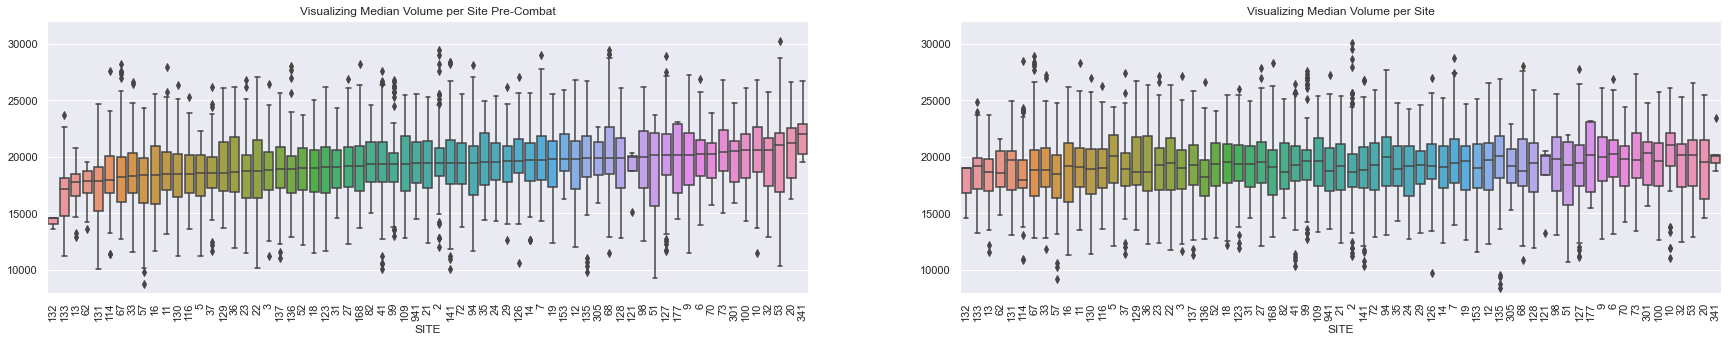

In [15]:
# Boxplots of Median Volume per site
plt.figure(figsize = (30,5))
plt.subplot(1,2,2)
sns.boxplot(data = df_harmonized_adni, x = 'SITE', y = np.squeeze(median_vol), order = sites_ordered)
plt.title('Visualizing Median Volume per Site')
plt.xticks(rotation=90)
plt.ylim([8000,32000])

plt.subplot(1,2,1)
sns.boxplot(data = df_adni, x = 'SITE', y = np.squeeze(median_vol_pre), order = sites_ordered)
plt.title('Visualizing Median Volume per Site Pre-Combat')
plt.xticks(rotation=90)
plt.ylim([8000,32000])

### Comparing Pre- and Post-Harmonization Results per Site

In [16]:
def boxplots_per_site(df, df_new, ROI, batch):
# Function which compares the ROI values per site pre- and post-harmonization. 

    # determining the limits of our boxplot
    ylim_max = max([*df[ROI].values, *df_new[ROI].values]) 
    ylim_min = min([*df[ROI].values, *df_new[ROI].values]) 
     
    # Boxplots of Median Volume per site
    plt.figure(figsize = (20,5))
    plt.subplot(1,2,1)
    sns.boxplot(data = df, x = batch, y = ROI, order = sites_ordered)
    plt.title(ROI + ' per '  + batch + ' Pre-Combat')
    plt.xticks(rotation=90)
    plt.ylim([ylim_min, ylim_max])

    plt.subplot(1,2,2)
    sns.boxplot(data = df_new, x = batch, y = ROI, order = sites_ordered)
    plt.title(ROI + ' per '  + batch + ' Post-Combat')
    plt.xticks(rotation=90)
    plt.ylim([ylim_min, ylim_max])

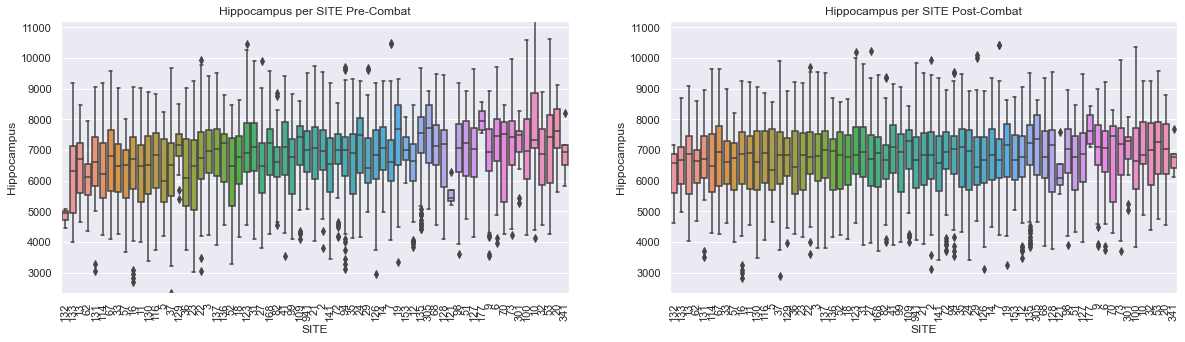

In [17]:
# The function is called in the cells below for different ROIs
boxplots_per_site(df_adni, df_harmonized_adni, 'Hippocampus', 'SITE')

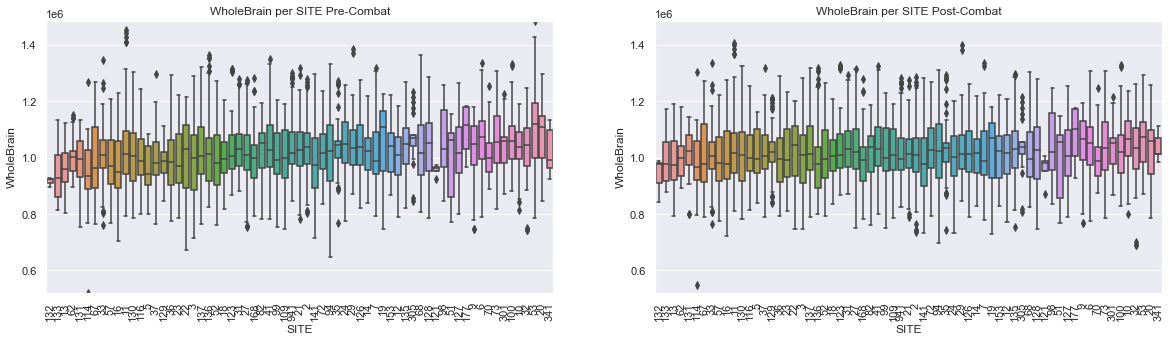

In [18]:
boxplots_per_site(df_adni, df_harmonized_adni, 'WholeBrain', 'SITE')

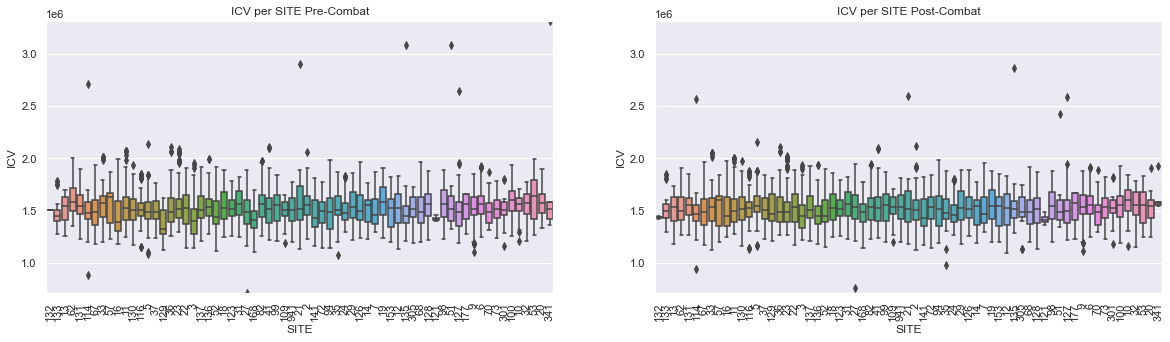

In [19]:
boxplots_per_site(df_adni, df_harmonized_adni, 'ICV', 'SITE')

The results above show that neuroCombat tends to bring all the data towards a common mean and tends to reduce the variance per site as well. If ```mean_only = True ```, then neuroCombat will only adjust the means and not the variances. 

The function below can be used to visualise the distribution of certain ROI value, pre- and post-harmonization, for each participant group (healthy controls, dementia, or MCI). 

In [20]:
# HC vs PD Histograms/ Scatterplots (for all sites combined)

def ROI_distribution_per_DX(df, df_new, ROI, batch, plot_type):
# This function can be used to compare the distribution of ROI values pre- and post-combat for all three participant groups. 
# There is a choice of a stacked plot or barplot. 

    # finding the limits of the x-axis 
    xlim_max = max([*df[ROI].values, *df_new[ROI].values])
    xlim_min = min([*df[ROI].values, *df_new[ROI].values]) 
    
    # defining each diagnosis subgroup - CN, MCI and Dementia 
    df_controls = df[df['DX']== 'CN'].reset_index()
    df_new_controls = df_new[df_new['DX']== 'CN'].reset_index()
    df_mci = df[df['DX']== 'MCI'].reset_index()
    df_new_mci = df_new[df_new['DX']== 'MCI'].reset_index()
    df_dementia = df[df['DX']== 'Dementia'].reset_index()
    df_new_dementia = df_new[df_new['DX']== 'Dementia'].reset_index()
    
    # Boxplots of Median Volume per cohort
    
    # Stacked
    if plot_type == 'stack':
        fig,ax = plt.subplots(1,3,figsize=(30,5),sharey=True)
    
        ax[0].hist(np.vstack((df_controls[ROI].values, df_new_controls[ROI].values)).T,density=True, histtype='bar', stacked=True)
        ax[0].set_xlim([xlim_min, xlim_max])
        ax[0].set_title('Visualizing ' + ROI + ' Distribution for Controls')
        ax[0].set_xlabel(ROI)
        ax[0].set_ylabel('Frequency')
        ax[0].legend(['Pre-Combat', 'Post-Combat'])

        ax[1].hist(np.vstack((df_mci[ROI].values, df_new_mci[ROI].values)).T,density=True, histtype='bar', stacked=True)
        ax[1].set_xlim([xlim_min, xlim_max])
        ax[1].set_title('Visualizing ' + ROI + ' Distribution Post Combat for MCI Patients')
        ax[1].set_xlabel(ROI)
        # ax[1].set_ylabel('Frequency')
        ax[1].legend(['Pre-Combat', 'Post-Combat'])
        
        ax[2].hist(np.vstack((df_dementia[ROI].values, df_new_dementia[ROI].values)).T,density=True, histtype='bar', stacked=True)
        ax[2].set_xlim([xlim_min, xlim_max])
        ax[2].set_title('Visualizing ' + ROI + ' Distribution Post Combat for Dementia Patients')
        ax[2].set_xlabel(ROI)
        # ax[1].set_ylabel('Frequency')
        ax[2].legend(['Pre-Combat', 'Post-Combat'])
    
    # Bar
    if plot_type == 'bar': 
        fig,ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
        
        ax[0].hist(np.vstack((df_controls[ROI].values, df_new_controls[ROI].values)).T,density=True, histtype='bar')
        ax[0].set_xlim([xlim_min, xlim_max])
        ax[0].set_title('Visualizing ' + ROI + ' Distribution for Controls')
        ax[0].set_xlabel(ROI)
        ax[0].set_ylabel('Frequency')
        ax[0].legend(['Pre-Combat', 'Post-Combat'])

        ax[1].hist(np.vstack((df_mci[ROI].values, df_new_mci[ROI].values)).T,density=True, histtype='bar')
        ax[1].set_xlim([xlim_min, xlim_max])
        ax[1].set_title('Visualizing ' + ROI + ' Distribution Post Combat for MCI Patients')
        ax[1].set_xlabel(ROI)
        # ax[1].set_ylabel('Frequency')
        ax[1].legend(['Pre-Combat', 'Post-Combat'])
        
        ax[2].hist(np.vstack((df_dementia[ROI].values, df_new_dementia[ROI].values)).T,density=True, histtype='bar')
        ax[2].set_xlim([xlim_min, xlim_max])
        ax[2].set_title('Visualizing ' + ROI + ' Distribution Post Combat for mci')
        ax[2].set_xlabel(ROI)
        # ax[1].set_ylabel('Frequency')
        ax[2].legend(['Pre-Combat', 'Post-Combat'])
        

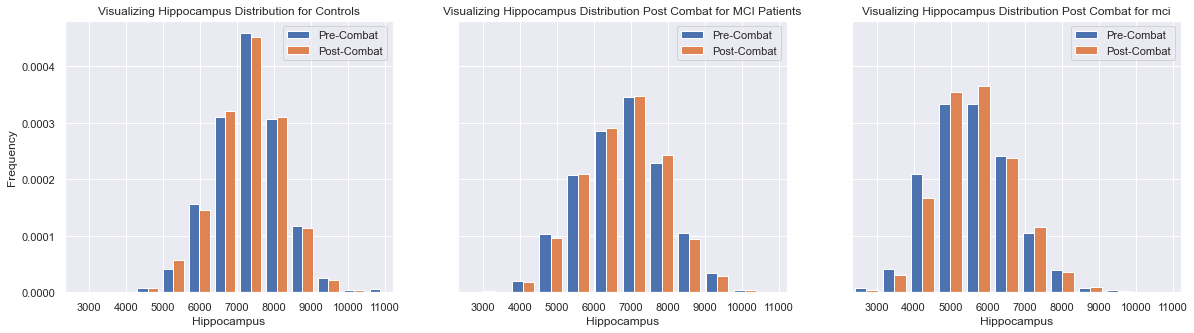

In [21]:
ROI_distribution_per_DX(df_adni, df_harmonized_adni, 'Hippocampus', 'SITE','bar')

### Distribution of Covariates

neuroCombat was not given the covariate data to harmonize (and the covariates were not replaced when creating df_harmonized_adni). Therefore, the distribution of covariates has not changed. The code showing this is commented below, just in case there was any doubt. However, the effects these covariates have on the data (volume measures) is also preserved by neuroCombat. This is not shown here, but is left as an exercise for those who are keen. 

In [22]:
# # Boxplots of Age per Site
# fig = plt.figure(figsize = (20,5))
# plt.subplot(1,2,1)
# sns.boxplot(data = df_adni, x = 'SITE', y = 'AGE', palette="Set2")
# plt.title('Age per Site')
# plt.xlabel('Site')
# plt.ylabel('Age')

# plt.subplot(1,2,2)
# sns.boxplot(data = df_harmonized_adni, x = 'SITE', y = 'AGE', palette="Set2")
# plt.title('Age per Site')
# plt.xlabel('Site')
# plt.ylabel('Age')

# # Boxplots of Education per Site
# fig = plt.figure(figsize = (20,5))
# plt.subplot(1,2,1)
# sns.set(rc={'figure.figsize':(20,5)})
# sns.boxplot(data = df_adni, x = 'SITE', y = 'PTEDUCAT', palette="Set2")
# plt.title('Education per Site')
# plt.xlabel('Site')
# plt.ylabel('Education')

# plt.subplot(1,2,2)
# sns.set(rc={'figure.figsize':(20,5)})
# sns.boxplot(data = df_harmonized_adni, x = 'SITE', y = 'PTEDUCAT', palette="Set2")
# plt.title('Education per Site')
# plt.xlabel('Site')
# plt.ylabel('Education')

# # Barplot of Gender count per site 
# fig = plt.figure(figsize = (20,5))
# sns.catplot(
#     data=df_adni, kind="count",
#     x="SITE", hue="PTGENDER",
#     palette="Set2",edgecolor="0.5", height=5, aspect=20/5)
# plt.title('Gender Count per Site')
# plt.xlabel('Site')
# plt.ylabel('Count')

# fig = plt.figure(figsize = (20,5))
# sns.catplot(
#     data=df_harmonized_adni, kind="count",
#     x="SITE", hue="PTGENDER",
#     palette="Set2",edgecolor="0.5", height=5, aspect=20/5)
# plt.title('Gender Count per Site')
# plt.xlabel('Site')
# plt.ylabel('Count')

## Conclusion <a class="anchor" id="sixth-bullet"></a>

In summary, we applied neuroCombat to ADNI; specifically, to a few FreeSurfer volume measures. While preserving covariate effects, neuroCombat adjusted the FreeSurfer volume measures based on the site the data was acquired. It is well-known that the exact site of a scan can vastly vary the outcome. Therefore, this is a useful tool to try to undo such inter-site variation. 